In [1]:
import scanpy as sc
import squidpy as sq
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
adata = sc.read_h5ad("Mouse_brain.h5ad")
adata

AnnData object with n_obs × n_vars = 38746 × 26177
    obs: 'annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'annotation_colors'
    obsm: 'spatial'
    varm: 'PCs'
    layers: 'count'

In [3]:
del adata.uns['annotation_colors']

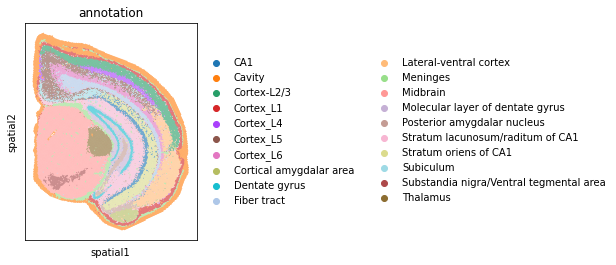

In [4]:
sc.pl.spatial(adata, color="annotation", size=1, spot_size=1, save="origin.png")

### calculate cluster neighbors

In [20]:
sq.gr.spatial_neighbors(adata,coord_type="generic",radius=20)
cell_connection = adata.obsp['spatial_connectivities']
anno = list(adata.obs['annotation'].unique())

In [21]:
con_d ={}
for i in range(len(anno)):
    matrix = cell_connection[adata.obs['annotation'] == anno[i],:]
    con_d[anno[i]] = {}
    for j in range(len(anno)):
        if i==j:
            con_d[anno[i]][anno[j]]=0
            continue
        matrix2 = matrix[:,adata.obs['annotation'] == anno[j]]
        con_d[anno[i]][anno[j]] = np.sum(matrix2) / np.sqrt(np.sum(adata.obs['annotation'] == anno[i]))
con_d = pd.DataFrame(con_d)
con_d_bkp = con_d.copy()
con_d = con_d*100 / con_d.max().max()

for i in range(len(anno)):
    for j in range(len(anno)):
        con_d[anno[i]][anno[j]] = max(con_d[anno[i]][anno[j]],con_d[anno[j]][anno[i]])

In [22]:
area_d ={}
for i in range(len(anno)):
    area_d[anno[i]] = {}
    for j in range(len(anno)):
        if i==j:
            area_d[anno[i]][anno[j]]=0
            continue
        area_d[anno[i]][anno[j]] = np.sqrt(np.sum(adata.obs['annotation'] == anno[i])*np.sum(adata.obs['annotation'] == anno[j]))
area_d = pd.DataFrame(area_d)
area_d = area_d*100 / area_d.max().max()

In [23]:
df = con_d.where(con_d > area_d, area_d)
df = np.sqrt(df)*10

In [24]:
#df.to_csv("cell_connection_statistic.csv", index=True, sep=',')

### switch neighbors into cluster distance

In [25]:
df2 = df.copy()

### reduce dimensionality

In [26]:
from sklearn.manifold import MDS

In [27]:
from sklearn.datasets import load_digits

In [28]:
embedding = MDS(
    n_components=3,
    dissimilarity="precomputed",
    #max_iter=2000000,
    random_state=123,
)

In [29]:
df3 = embedding.fit_transform(df2)

In [30]:
np.max(df3[:,0]) - np.min(df3[:,0]), np.max(df3[:,1]) - np.min(df3[:,1]), np.max(df3[:,2]) - np.min(df3[:,2])

(79.94527851455402, 97.52711525222398, 74.92874507552315)

In [31]:
#RGB
df3 = ( (df3-np.min(df3)) / (np.max(df3)-np.min(df3)) )*255

### switch 3-dimension value into RGB color

In [32]:
df4 = df3.copy()
df4 = pd.DataFrame(df4)
df4.index = df.index
df4 = df4.sort_index(ascending=True)
df4 = df4.astype(int)

def RGB_to_Hex(tmp):
    rgb = tmp.split(',')#将RGB格式划分开来
    strs = '#'
    for i in rgb:
        num = int(i)#将str转int
        #将R、G、B分别转化为16进制拼接转换并大写
        strs += str(hex(num))[-2:].replace('x','0').upper()
        
    return strs

df4['color012'] = "color"
df4['color021'] = "color"
df4['color102'] = "color"
df4['color120'] = "color"
df4['color201'] = "color"
df4['color210'] = "color"
for i in range(df4.shape[0]):
    df4.iloc[i,3] = RGB_to_Hex(str(df4.iloc[i,0])+ "," + str(df4.iloc[i,1]) + "," + str(df4.iloc[i,2]))
    df4.iloc[i,4] = RGB_to_Hex(str(df4.iloc[i,0])+ "," + str(df4.iloc[i,2]) + "," + str(df4.iloc[i,1]))
    df4.iloc[i,5] = RGB_to_Hex(str(df4.iloc[i,1])+ "," + str(df4.iloc[i,0]) + "," + str(df4.iloc[i,2]))
    df4.iloc[i,6] = RGB_to_Hex(str(df4.iloc[i,1])+ "," + str(df4.iloc[i,2]) + "," + str(df4.iloc[i,0]))
    df4.iloc[i,7] = RGB_to_Hex(str(df4.iloc[i,2])+ "," + str(df4.iloc[i,0]) + "," + str(df4.iloc[i,1]))
    df4.iloc[i,8] = RGB_to_Hex(str(df4.iloc[i,2])+ "," + str(df4.iloc[i,1]) + "," + str(df4.iloc[i,0]))

In [33]:
df4

,0,1,2,color012,color021,color102,color120,color201,color210
CA1,187,91,167,#BB5BA7,#BBA75B,#5BBBA7,#5BA7BB,#A7BB5B,#A75BBB
Cavity,248,160,251,#F8A0FB,#F8FBA0,#A0F8FB,#A0FBF8,#FBF8A0,#FBA0F8
Cortex-L2/3,52,114,119,#347277,#347772,#723477,#727734,#773472,#777234
Cortex_L1,126,164,62,#7EA43E,#7E3EA4,#A47E3E,#A43E7E,#3E7EA4,#3EA47E
Cortex_L4,190,156,179,#BE9CB3,#BEB39C,#9CBEB3,#9CB3BE,#B3BE9C,#B39CBE
Cortex_L5,255,196,121,#FFC479,#FF79C4,#C4FF79,#C479FF,#79FFC4,#79C4FF
Cortex_L6,72,166,202,#48A6CA,#48CAA6,#A648CA,#A6CA48,#CA48A6,#CAA648
Cortical amygdalar area,155,153,165,#9B99A5,#9BA599,#999BA5,#99A59B,#A59B99,#A5999B
Dentate gyrus,193,129,127,#C1817F,#C17F81,#81C17F,#817FC1,#7FC181,#7F81C1
Fiber tract,196,156,75,#C49C4B,#C44B9C,#9CC44B,#9C4BC4,#4BC49C,#4B9CC4


### plot 

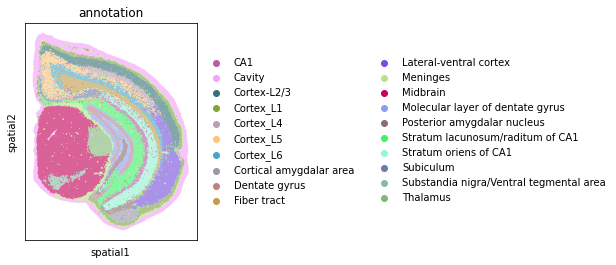

In [38]:
for i in range(3,len(df4.columns)):
    adata.uns['annotation_colors'] = df4.iloc[:,i]
    sc.pl.spatial(adata, img_key="hires", color="annotation", size=1, spot_size=1, save=df4.columns[i] + ".png")

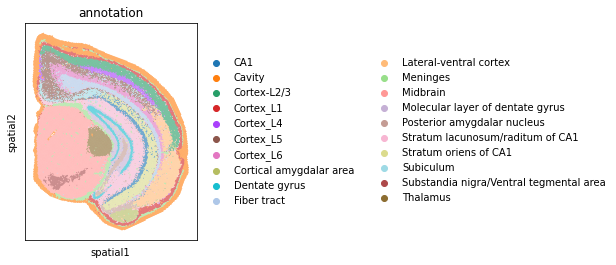

In [39]:
del adata.uns['annotation_colors']
sc.pl.spatial(adata, img_key="hires", color="annotation", size=1, spot_size=1)

### LAB to RGB

In [265]:
#L 0-100
df3[:,0] = ( (df3[:,0]-np.min(df3[:,0])) / (np.max(df3[:,0])-np.min(df3[:,0])) )*100
#A, B -128~127
df3[:,1] = ( (df3[:,1]-np.min(df3[:,1])) / (np.max(df3[:,1])-np.min(df3[:,1])) )*200 - 100
df3[:,2] = ( (df3[:,2]-np.min(df3[:,2])) / (np.max(df3[:,2])-np.min(df3[:,2])) )*200 - 100

In [64]:
from colormath.color_objects import LabColor, XYZColor, sRGBColor
from colormath.color_conversions import convert_color

In [266]:
for i in range(df3.shape[0]):
    lab = LabColor(df3[i,0], df3[i,1], df3[i,2])
    xyz = convert_color(lab, XYZColor)
    rgb = convert_color(xyz, sRGBColor)
    df3[i] = np.array(rgb.get_upscaled_value_tuple())
df3

array([[261., 189.,   0.],
       [290., 110., 170.],
       [  0., 222., 362.],
       [148.,  81., 129.],
       [  0.,  52., 212.],
       [131., 137., 309.],
       [ 74.,   0.,  22.],
       [177., 180., 202.],
       [288., 232., 355.],
       [  0.,  37.,  97.],
       [ 41.,  42.,  38.],
       [179., 125., 111.],
       [  0., 100., 189.],
       [193.,   0.,  39.],
       [  0., 149., 213.],
       [220.,   0., 201.],
       [ 62., 166., 125.],
       [110., 105., 127.],
       [ 89.,  52.,   0.],
       [  0.,  97.,   0.]])